# LangChain & LangGraph 입문

- LLM 애플리케이션을 만드는 프레임워크

https://python.langchain.com/docs/introduction/

## Chat Google Genai 설치
```
pip install -U langchain-google-genai
```

Google API KEY 발급
https://aistudio.google.com/app/apikey?hl=ko


In [ ]:
pip install langchain

In [ ]:
pip install -U langgraph langsmith

### API Key 설정

In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = 'Your API KEY'

In [32]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [3]:
llm.invoke('hi')

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--e474fee2-0944-4e46-ae64-e2ec1c4acd3e-0', usage_metadata={'input_tokens': 2, 'output_tokens': 164, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 154}})

### LangChain 기초 - Prompt와 LLM chain

In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


prompt = ChatPromptTemplate.from_template(
    "{topic}에 대해 세 문장으로 간결하게 설명해주세요."
)
output_parser = StrOutputParser()
chain = prompt | llm | output_parser
response = chain.invoke({"topic": "인공지능"})
print(response)

인공지능(AI)은 기계가 인간처럼 사고하고 학습하며 문제를 해결하는 능력을 갖추도록 하는 기술입니다. 데이터를 분석하고 패턴을 인식하여 의사결정을 내리거나 특정 작업을 수행합니다. 궁극적으로는 복잡한 작업을 자동화하고 인간의 능력을 보완하며 확장하는 것을 목표로 합니다.


In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


prompt = ChatPromptTemplate.from_template(
    "Answer the following question in English only: {input}"
)
output_parser = StrOutputParser()  # LLM의 출력(ChatMessage)을 간단한 문자열(string) 형태로 변환합니다.
chain = prompt | llm | output_parser   # 프롬프트, LLM, ouput_parser를 연결하는 chain을 정의합니다.
response = chain.invoke({"input" : "인공지능이란?"})
print(response)

Artificial intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think like humans and mimic their actions. The term can also be applied to any machine that exhibits traits associated with a human mind, such as learning and problem-solving.


### React Agent 만들기
- memory, tool 결합

In [4]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
memory = MemorySaver()
model = init_chat_model("google_genai:gemini-2.5-flash")
tools = []
agent_executor = create_react_agent(model, tools, checkpointer=memory)

In [5]:
config = {"configurable": {"thread_id": "abc123"}}
input_message = {
    "role": "user",
    "content": "Hi, I'm Bob and I live in SF.",
}
for step in agent_executor.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, I'm Bob and I live in SF.
================================== Ai Message ==================================

Hi Bob, nice to meet you! San Francisco is a fantastic city.

How can I help you today, or what's on your mind?


In [6]:
config = {"configurable": {"thread_id": "abc123"}}
input_message = {
    "role": "user",
    "content": "Do you know where i live?",
}
for step in agent_executor.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know where i live?
================================== Ai Message ==================================

Yes, based on what you told me in your first message, you live in **San Francisco (SF)**.

As an AI, I only know the information you provide me during our conversation, so I don't have any external knowledge about your personal location beyond what you explicitly state.


### LangChain의 Tool 정의

- 특정 Task를 요청받았을 때, 사용자가 미리 정의해준 tool을 활용해서 문제를 해결할 수 있게 함

In [7]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
   """Multiply two numbers."""
   return a * b


In [8]:
tools = [multiply]
agent_executor = create_react_agent(model, tools, checkpointer=memory)

In [9]:
config = {"configurable": {"thread_id": "abc123"}}
input_message = {
    "role": "user",
    "content": "31 곱하기 27은?",
}
for step in agent_executor.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

31 곱하기 27은?
================================== Ai Message ==================================
Tool Calls:
  multiply (91743f73-44fe-4a27-b021-117785d011a1)
 Call ID: 91743f73-44fe-4a27-b021-117785d011a1
  Args:
    b: 27.0
    a: 31.0
================================= Tool Message =================================
Name: multiply

837
================================== Ai Message ==================================

31 곱하기 27은 837입니다.


# LangGraph

### 1. LLM 정의

In [54]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

### 2. State Graph 정의
- class State라는 클래스에, 이후에 정의할 변수의 타입을 지정해주어야 합니다.
- 

In [55]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    # messages라는 변수는 리스트이며, add_messages라는 설명서를 덧붙인다는 의미
    # add_messages : 메시지 리스트를 덮어쓰지 않고, 새로운 메시지를 뒤에 추가해나간다는 의미
    


graph_builder = StateGraph(State)

In [56]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)   # .add_node로 그래프의 노드를 추가합니다.

In [10]:
graph_builder.add_edge(START, "chatbot")   # 어디서 어디로 보낼건지 정의해줘야 합니다. START --> chatbot

In [11]:
graph_builder.add_edge("chatbot", END)  # chatbot --> END

In [12]:
graph = graph_builder.compile()

### 그래프 시각화

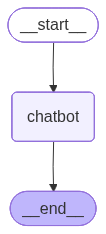

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  안녕


Assistant: 안녕!


User:  0.99999999999999는 1이라고 할 수 있니?


Assistant: 아니요, 수학적으로 엄밀히 말하면 **0.99999999999999는 1이 아닙니다.**

*   **수학적으로:** 0.99999999999999는 1보다 아주 미세하게 작습니다. 정확히 말하면 1에서 0.00000000000001을 뺀 값입니다.
    *   1 - 0.99999999999999 = 0.00000000000001

*   **하지만:**
    *   만약 **0.999... (9가 무한히 반복되는 숫자)** 였다면, 이 숫자는 수학적으로 **정확히 1과 같습니다.** (이것은 많은 사람들이 헷갈려 하는 부분이지만, 수학적으로 증명된 사실입니다.)
    *   질문하신 숫자는 9가 유한하게 (14개) 반복되므로 1과 같지 않습니다.

*   **실용적인 관점에서는:** 일상생활이나 특정 계산에서 매우 작은 오차를 무시해도 되는 경우라면 '거의 1이다' 또는 '1로 간주할 수 있다'고 말할 수는 있습니다. 예를 들어, 컴퓨터의 부동소수점 연산에서는 이 정도의 차이는 무시되거나 반올림되어 1로 처리될 수도 있습니다.

**결론적으로, 수학적으로는 1이 아니지만, 실용적인 관점에서는 1에 매우 가깝습니다.**


User:  q


Goodbye!


### 그래프에 Tool 추가

In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import json
from langchain_core.messages import ToolMessage, HumanMessage


class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [12]:
from langchain_core.tools import tool
@tool
def multiply(a: int, b: int) -> int:
   """Multiply two numbers."""
   return a * b

In [13]:
tools = [multiply]
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result) if not isinstance(tool_result, str) else tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [14]:
graph_builder = StateGraph(State)
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [15]:
llm_with_tools = llm.bind_tools(tools)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [16]:
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [17]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

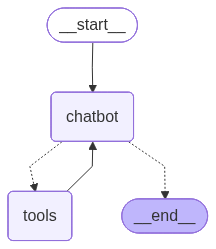

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  31 곱하기 2


Assistant: 
Assistant: 62
Assistant: 31 곱하기 2는 62입니다.


User:  q


Goodbye!


In [21]:
from langchain_core.messages import AIMessage
def stream_graph_updates_verbose(user_input: str):
    """모든 중간 단계를 자세히 출력하는 함수"""
    inputs = {"messages": [HumanMessage(content=user_input)]}

    print("--- Agent Start ---")
    for event in graph.stream(inputs, stream_mode="values"):
        message = event["messages"][-1]
        
        # AIMessage이면서 tool_calls가 있는 경우 (계획 단계)
        if isinstance(message, AIMessage) and message.tool_calls:
            print(f"🤖 [AIMessage]: Tool Call Planned -> {message.tool_calls[0]['name']}({message.tool_calls[0]['args']})")
        
        # ToolMessage인 경우 (실행 결과)
        elif isinstance(message, ToolMessage):
            print(f"🛠️ [ToolMessage]: Tool Result -> {message.content}")

        # AIMessage이면서 최종 답변인 경우
        elif isinstance(message, AIMessage) and message.content:
            print(f"💬 [AIMessage]: Final Answer -> {message.content}")
    print("--- Agent End ---")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates_verbose(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates_verbose(user_input)
        break

User:  61 곱하기 2


--- Agent Start ---
🤖 [AIMessage]: Tool Call Planned -> multiply({'b': 2.0, 'a': 61.0})
🛠️ [ToolMessage]: Tool Result -> 122
💬 [AIMessage]: Final Answer -> 61 곱하기 2는 122입니다.
--- Agent End ---


User:  q


Goodbye!


# 실습 과제 1

지금까지 배운 LangChain 기초를 토대로, 아래 함수를 LLM의 tool로 등록하여, 두 날짜를 입력했을 때 두 날짜 사이의 전체 일수를 계산해주는 시스템을 구현

입력 : 2025년 12월 1일과 2025년 9월 16일은 몇 일 차이가 나?

In [4]:
from datetime import datetime

def calculate_days_between(start_date: str, end_date: str) -> int:
    """두 날짜 사이의 전체 일수를 계산합니다. 날짜는 'YYYY-MM-DD' 형식이어야 합니다."""
    try:
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
        delta = abs((end - start).days)
        return delta
    except ValueError:
        return "날짜 형식이 잘못되었습니다. 'YYYY-MM-DD' 형식으로 입력해주세요."

# 함수 테스트
print(calculate_days_between("2025-01-01", "2025-12-31"))

364


================================ Human Message =================================

2025년 12월 1일과 2025년 9월 16일은 몇 일 차이가 나?
================================== Ai Message ==================================
Tool Calls:
  calculate_days_between (6a1066be-f05e-4e2b-9c71-e35abecc32ad)
 Call ID: 6a1066be-f05e-4e2b-9c71-e35abecc32ad
  Args:
    start_date: 2025-09-16
    end_date: 2025-12-01
================================= Tool Message =================================
Name: calculate_days_between

76
================================== Ai Message ==================================

2025년 9월 16일과 2025년 12월 1일은 76일 차이가 납니다.
